# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [147]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKmodel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [191]:
model = HANKModelClass(name='baseline')
#print(model)

# Step 1: Steady state

In [192]:
model.find_ss(do_print=True)

Z_N =  1.8317472056530812 Z_L =  1.0 Q = 0.5 M_N = 0.3215612019607193 M_L = 0.22511687686693685 beta =  0.9875 N_N = 0.4363938107474746 N_L = 0.27735888986012064
Z_N =  1.8317472056530812 Z_L =  1.0 Q = 0.5 M_N = 0.3215612019607193 M_L = 0.22511687686693685 beta =  0.9875 N_N = 0.4363938107474746 N_L = 0.27735888986012064
Z_N =  1.8317472056530812 Z_L =  1.0 Q = 0.5 M_N = 0.3215612019607193 M_L = 0.22511687686693685 beta =  0.9875 N_N = 0.4363938107474746 N_L = 0.27735888986012064
Z_N =  1.8317472056530812 Z_L =  1.0 Q = 0.5 M_N = 0.3215612003635075 M_L = 0.22511688022143972 beta =  0.9875 N_N = 0.4363938085798831 N_L = 0.27735889399309016
Z_N =  1.8317472056530812 Z_L =  1.0 Q = 0.5 M_N = 0.3215612019607193 M_L = 0.22511687686693685 beta =  0.9875000147148967 N_N = 0.4363938107474746 N_L = 0.27735888986012064
Z_N =  1.8317471783579211 Z_L =  1.0 Q = 0.5000000074505806 M_N = 0.3215612003635075 M_L = 0.22511687686693685 beta =  0.9875 N_N = 0.43639380857988314 N_L = 0.27735888986012064


In [ ]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 1.1 secs [663 iterations]


In [ ]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [ ]:
((par.mu_N**(par.gamma_N-1)-par.alpha_N*ss.pm**(1-par.gamma_N))/(1-par.alpha_N))**(1/(1-par.gamma_N))*(((ss.C_hh**(par.sigma)*par.alpha_N*ss.C_HAT_N_hh)**(-1/par.gamma_N)*ss.ELL_hh**(-par.nu))/ss.Z_N)

41.74113485083192

In [ ]:
print("Steady state W_L, W_N, Q = ", ss.w_L, ss.w_N, ss.Q)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
#print("Steady state interest rate", ss.r)
print("steady state consumption C_hh", ss.C_hh,"C_Lhh", ss.Q*ss.C_L_hh,"C_Nhh", ss.C_N_hh)
print("Steady state laborsupply ell ", ss.c)
print("varphi= ", par.varphi, "beta = ", par.beta)
print(ss.N_N, ss.Y_N, ss.N_L, ss.Y_L)
ss.Z_N


Steady state W_L, W_N, Q =  0.949012491982491 0.5952795854571505 0.6272621177131283
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.6000000000002075 0.0
steady state consumption C_hh 0.7592933732584575 C_Lhh 0.026972557619492233 C_Nhh 0.024636482817872316
Steady state laborsupply ell  [[[0.2738063  0.27539605 0.27701389 ... 1.50653724 1.5154819  1.52450394]
  [0.3738783  0.37547492 0.37709736 ... 1.53490179 1.54368386 1.55254398]
  [0.51081625 0.51242089 0.51376193 ... 1.56911584 1.57770634 1.58637564]
  ...
  [0.82323742 0.82329562 0.82335453 ... 1.66386394 1.67195983 1.68013588]
  [0.97428044 0.97431736 0.97435473 ... 1.7310051  1.73878817 1.74665171]
  [1.13430147 1.13432885 1.13435656 ... 1.81785094 1.82527522 1.83277977]]]
varphi=  0.8 beta =  0.989348352271803
0.019797555973194887 0.045656374511076514 1.0883934128839619 1.5214431073380752


1.7382912742365708

## Policy functions

In [ ]:
#fig = plt.figure(figsize=(18,4),dpi=100)
#a_max = 500
#
## a. consumption
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,1)
#ax.set_title(f'consumption')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.legend(frameon=True)
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('consumption, $c_t$')
#
## b. saving
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,2)
#ax.set_title(f'saving')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('savings, $a_{t}$')
#
## c. labor supply
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,3)
#ax.set_title(f'labor_supply')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('labor supply, $n_{t}$')
#
#fig.tight_layout()

## Simulation

In [ ]:
#fig = plt.figure(figsize=(12,4),dpi=100)
#
## a. income
#ax = fig.add_subplot(1,2,1)
#ax.set_title('productivity')
#
#y = np.cumsum(np.sum(ss.D[0],axis=1))
#ax.plot(par.z_grid,y/y[-1])
#
#ax.set_xlabel('productivity, $z_{t}$')
#ax.set_ylabel('CDF')
#
## b. assets
#ax = fig.add_subplot(1,2,2)
#ax.set_title('savings')
#y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
#ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
#        
#ax.set_xlabel('assets, $a_{t}$')
#ax.set_ylabel('CDF')
#ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.3 secs
household problem simulated along transition in 2.4 secs



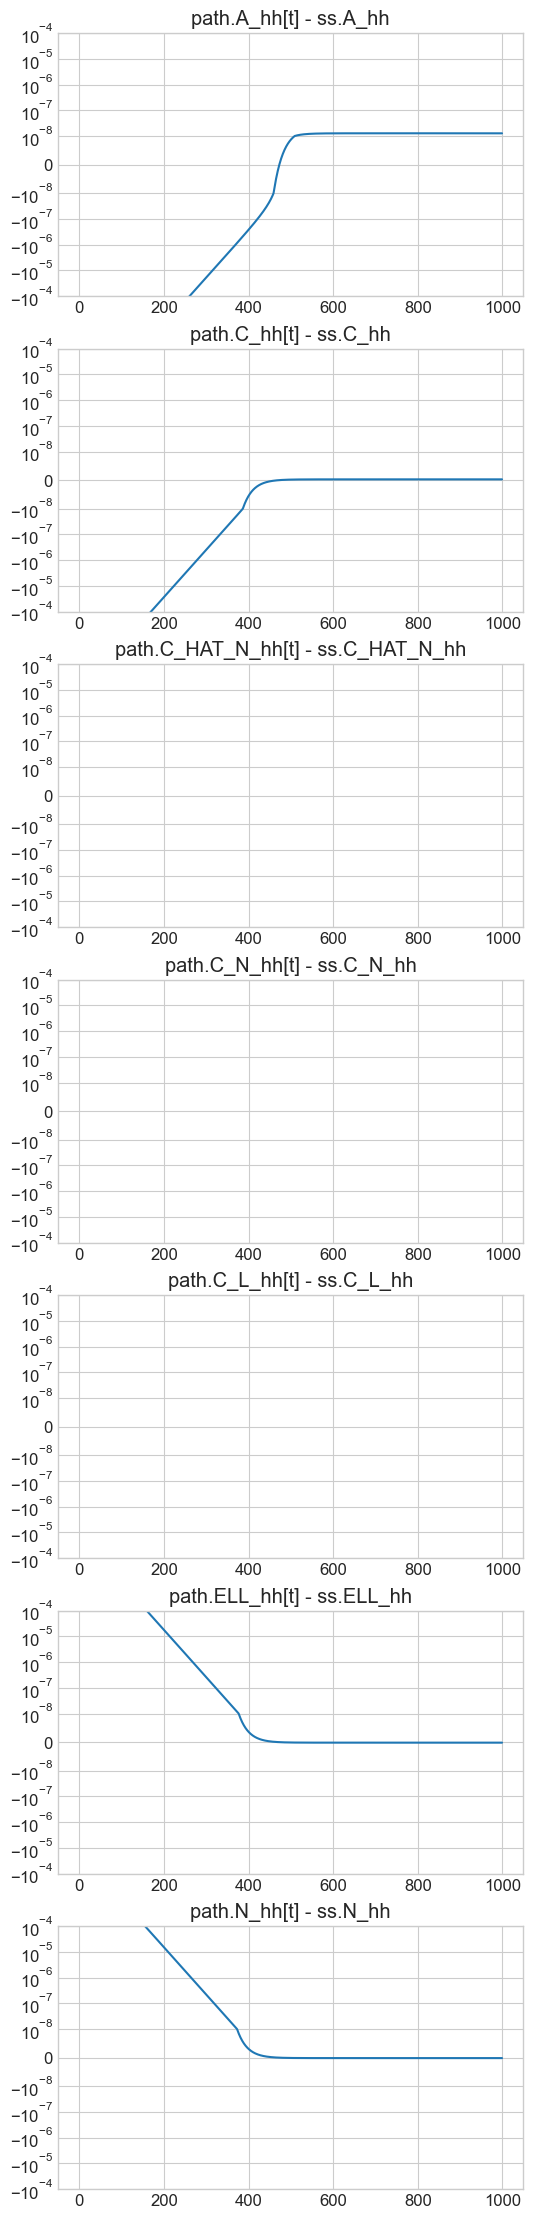

In [ ]:
model.test_hh_path()

**Full transition path:**

In [ ]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 = -6.6e-01, max abs.  6.6e-01
C_N            : t0 =  0.0e+00, max abs.  0.0e+00
C_L            : t0 =  0.0e+00, max abs.  0.0e+00
d_N            : t0 =  2.4e-01, max abs.  2.4e-01
d_L            : t0 =  4.2e-01, max abs.  4.2e-01
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 = -8.4e-01, max abs.  8.4e-01
N_N            : t0 = -2.1e-01, max abs.  2.1e-01
N_L            : t0 = -3.6e-01, max abs.  3.6e-01
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 =  0.0e+00, max abs.  0.0e+00
pm             : t0 =  0.0e+00, max abs.  0.0e+00
pi_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi_L           : t0 =  0.0e+00, max abs.  0.0e+00
adjcost_N      : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 2.7 secs]
finding Jacobian wrt. Q              : 50 100 150 [computed in 2.1 secs]
finding Jacobian wrt. d_L            : 50 100 150 [computed in 2.0 secs]
finding Jacobian wrt. d_N            : 50 100 150 [computed in 1.7 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 1.7 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 1.8 secs]
finding Jacobian wrt. w_N            : 50 100 150 [computed in 1.7 secs]
household Jacobian computed in 16.0 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Q               in 0.9 secs
curly_Y and curly_D calculated for d_L             in 0.9 secs
curly_Y and curly_D calculated for d_N             in 0.9 secs
curly_Y and curly_D calculated for r               in 0.9 secs
curly_Y and curly_D calculated for tau      

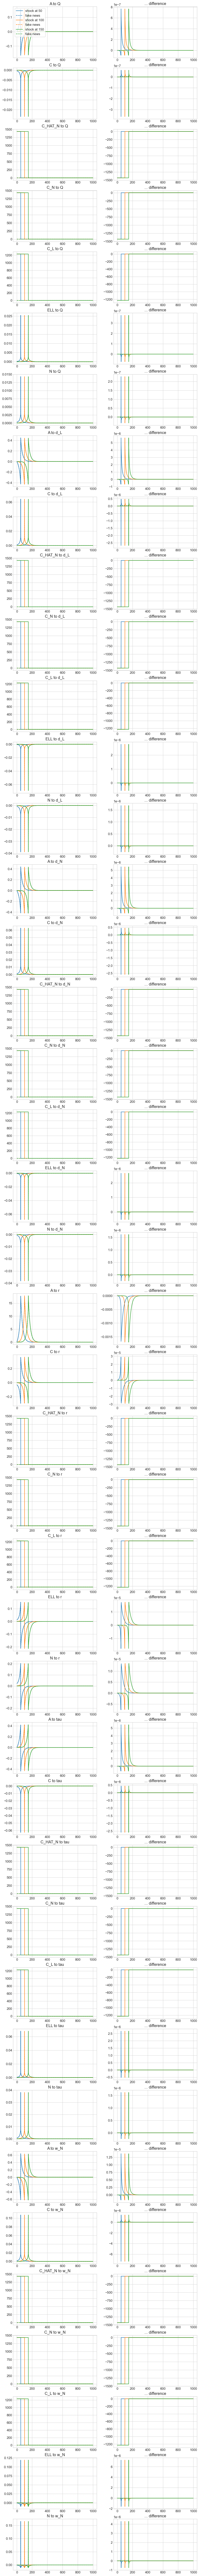

In [ ]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [ ]:
par.jump_pm = 0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error =      nan
   1.33e-02 in NKPC_res_N
   6.41e-03 in NKPC_res_L
   7.59e+00 in clearing_A
   7.59e-01 in clearing_N
   2.64e-01 in clearing_C_N
        nan in clearing_C_L
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...


ValueError: GEModelTools: Number of backtracks exceeds 30

## Plot transitions

### shocks ###


c:\users\johan\onedrive\økonomi ku\speciale\github repositories\numeconcopenhagen\gemodeltools\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


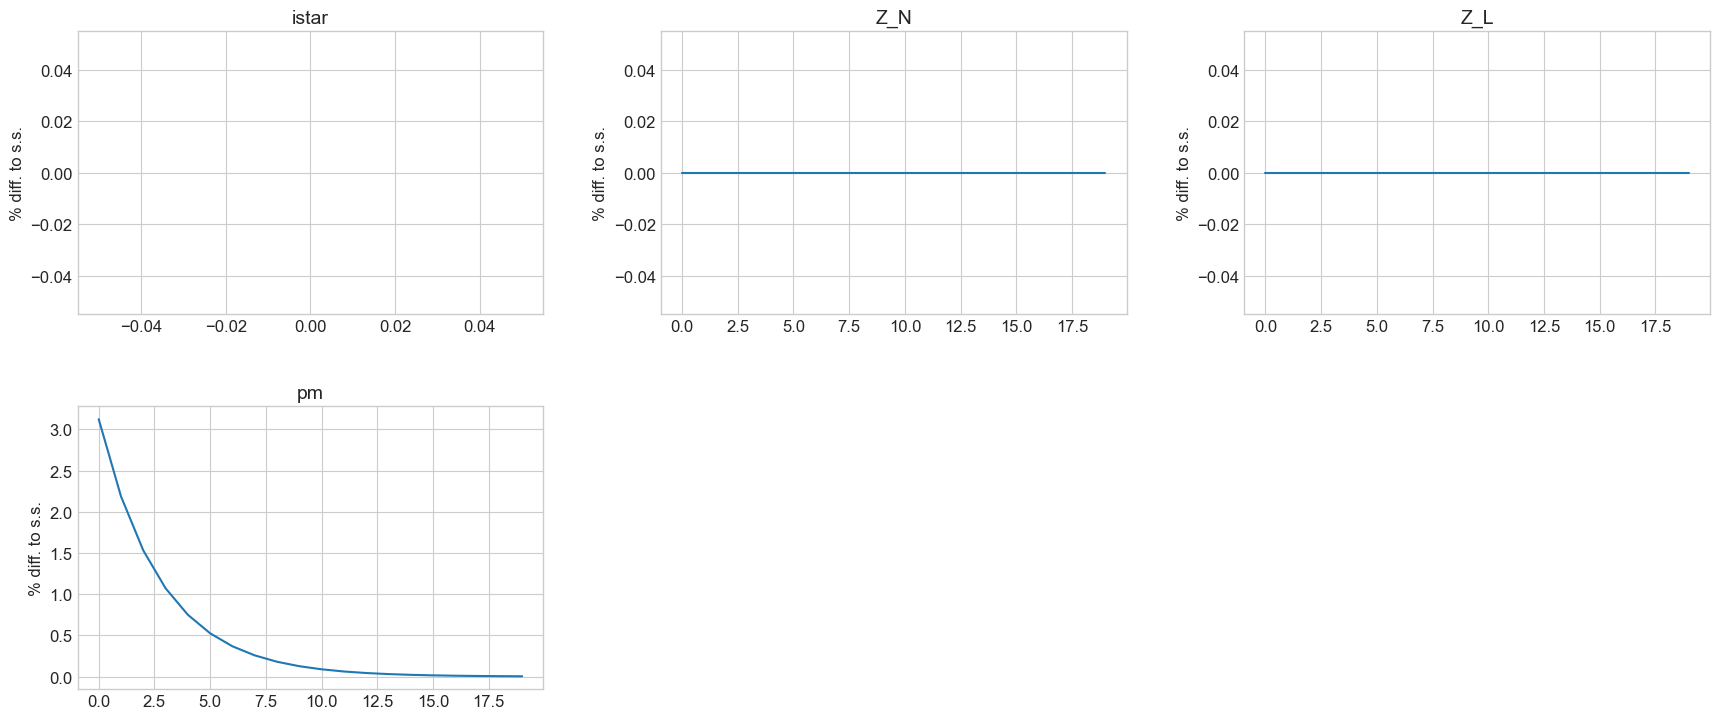


### varnames ###


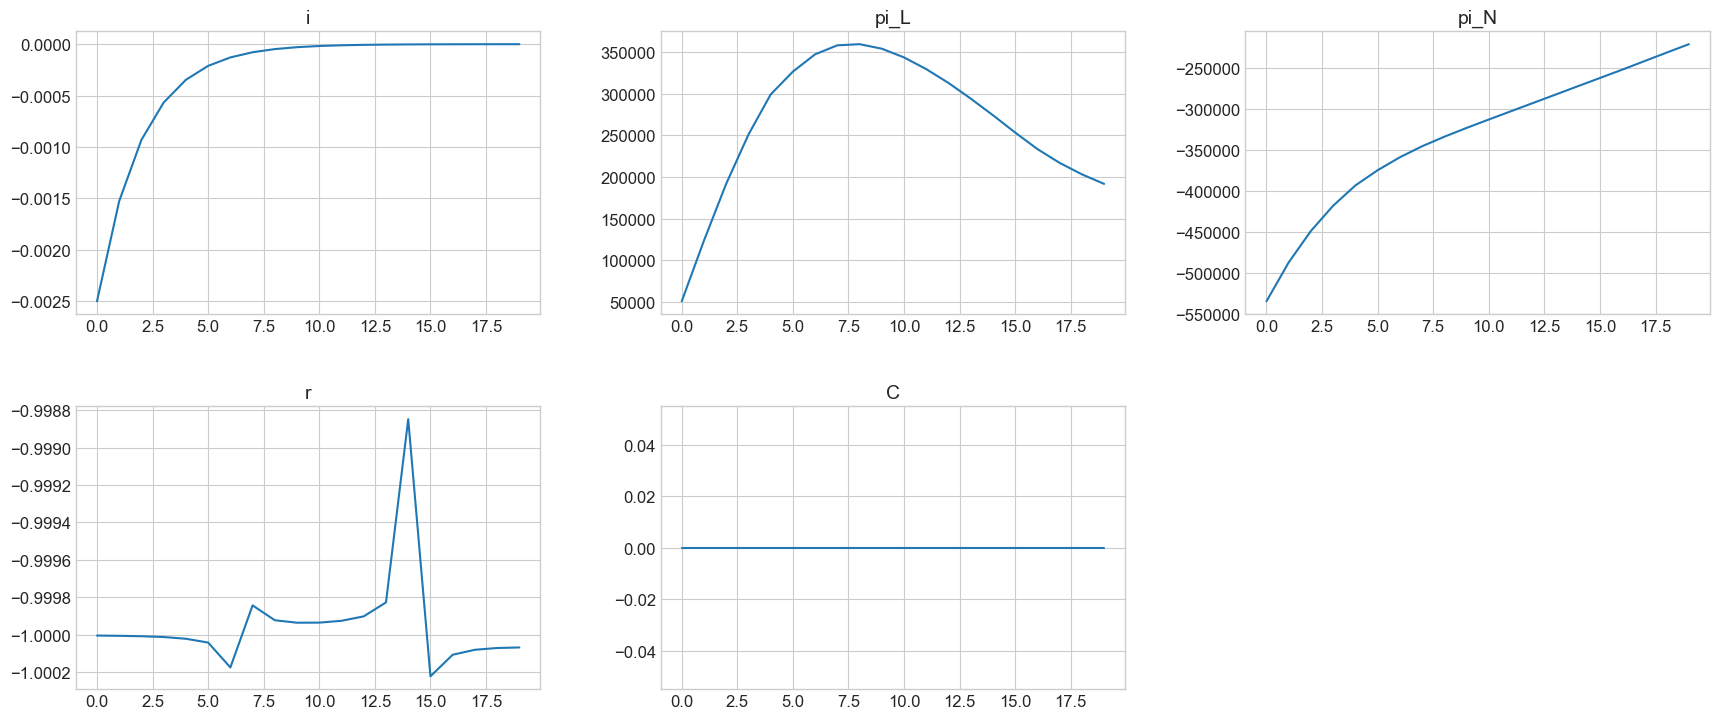


### tagets ###


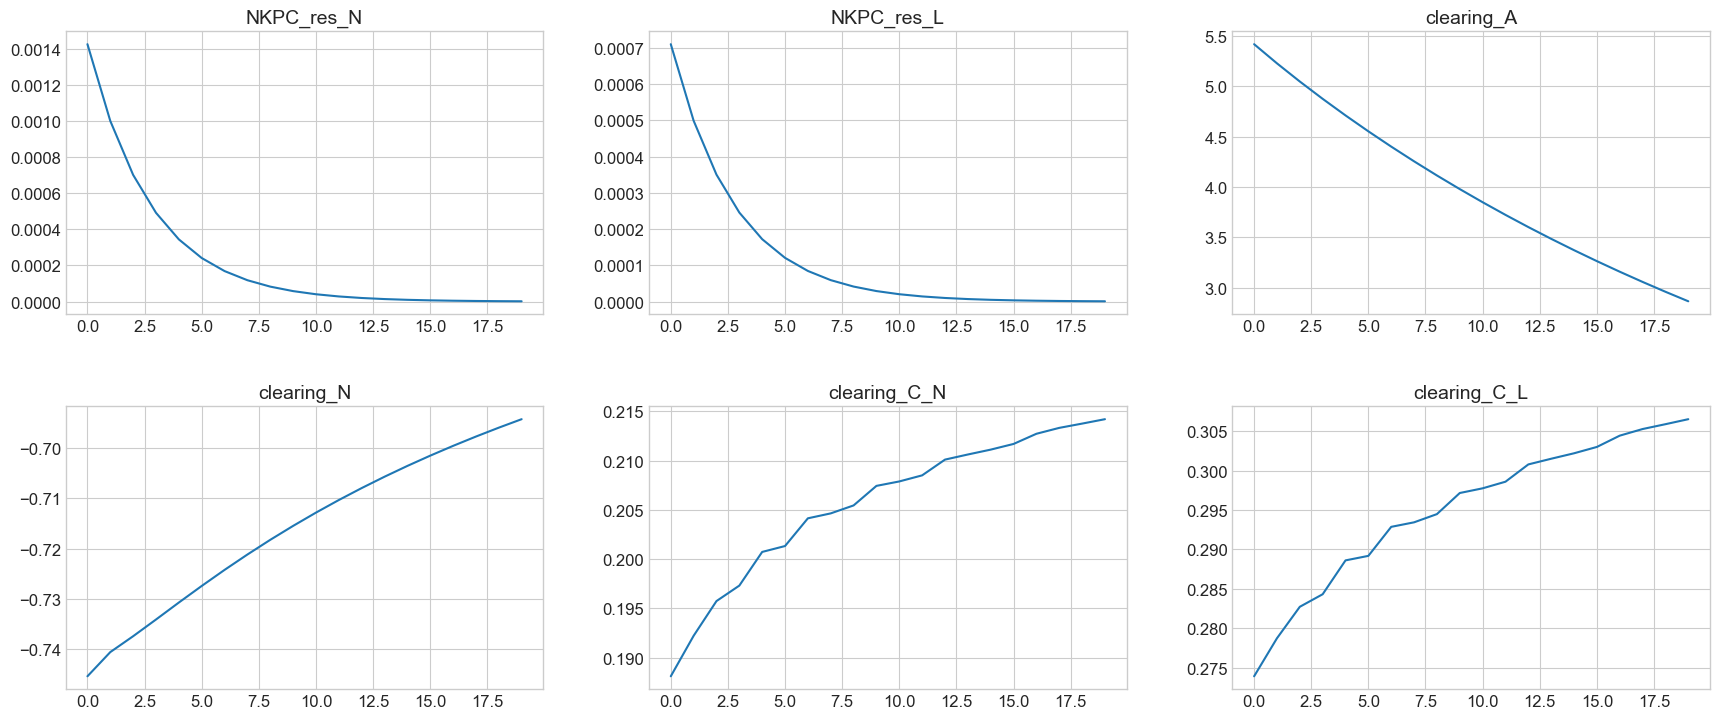

In [ ]:
paths = ['i','pi_L','pi_N','r','C']
lvl_value = ['i','pi_L','pi_N','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

linear transition path found in 7.7 secs [finding solution matrix: 7.2 secs]


### shocks ###


c:\users\johan\onedrive\økonomi ku\speciale\github repositories\numeconcopenhagen\gemodeltools\GEModelTools\figures.py:111: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(IRFvalue[:T_max]/ssvalue-1),ls='--',label='linear')


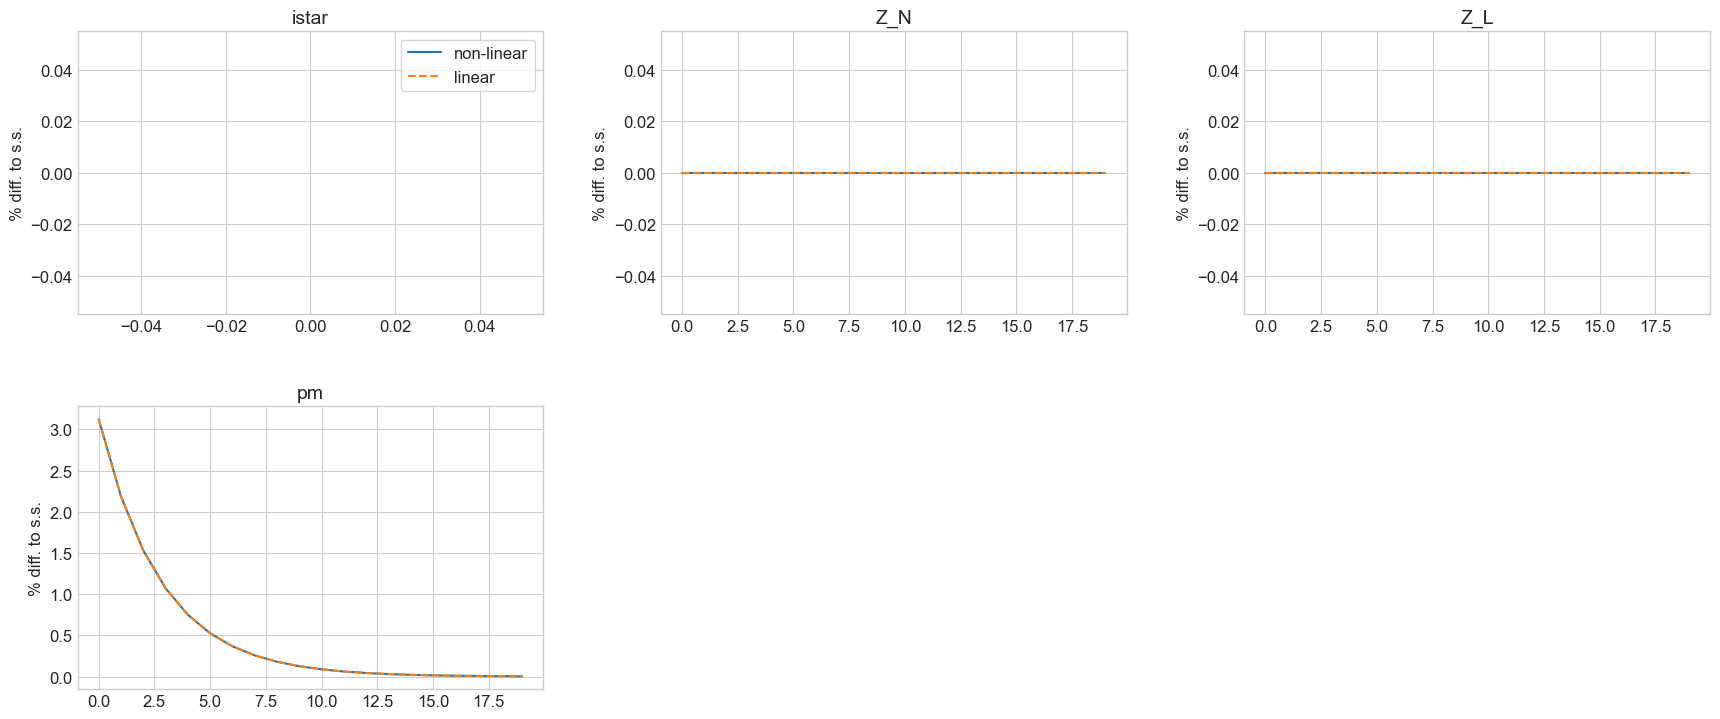


### varnames ###


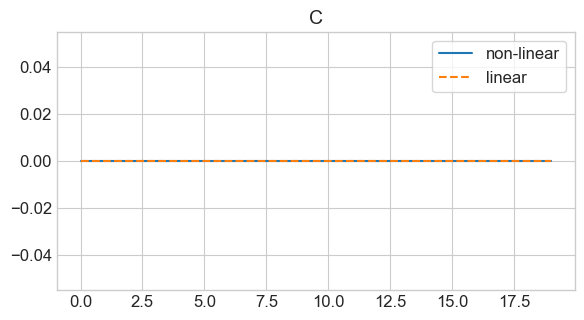


### tagets ###


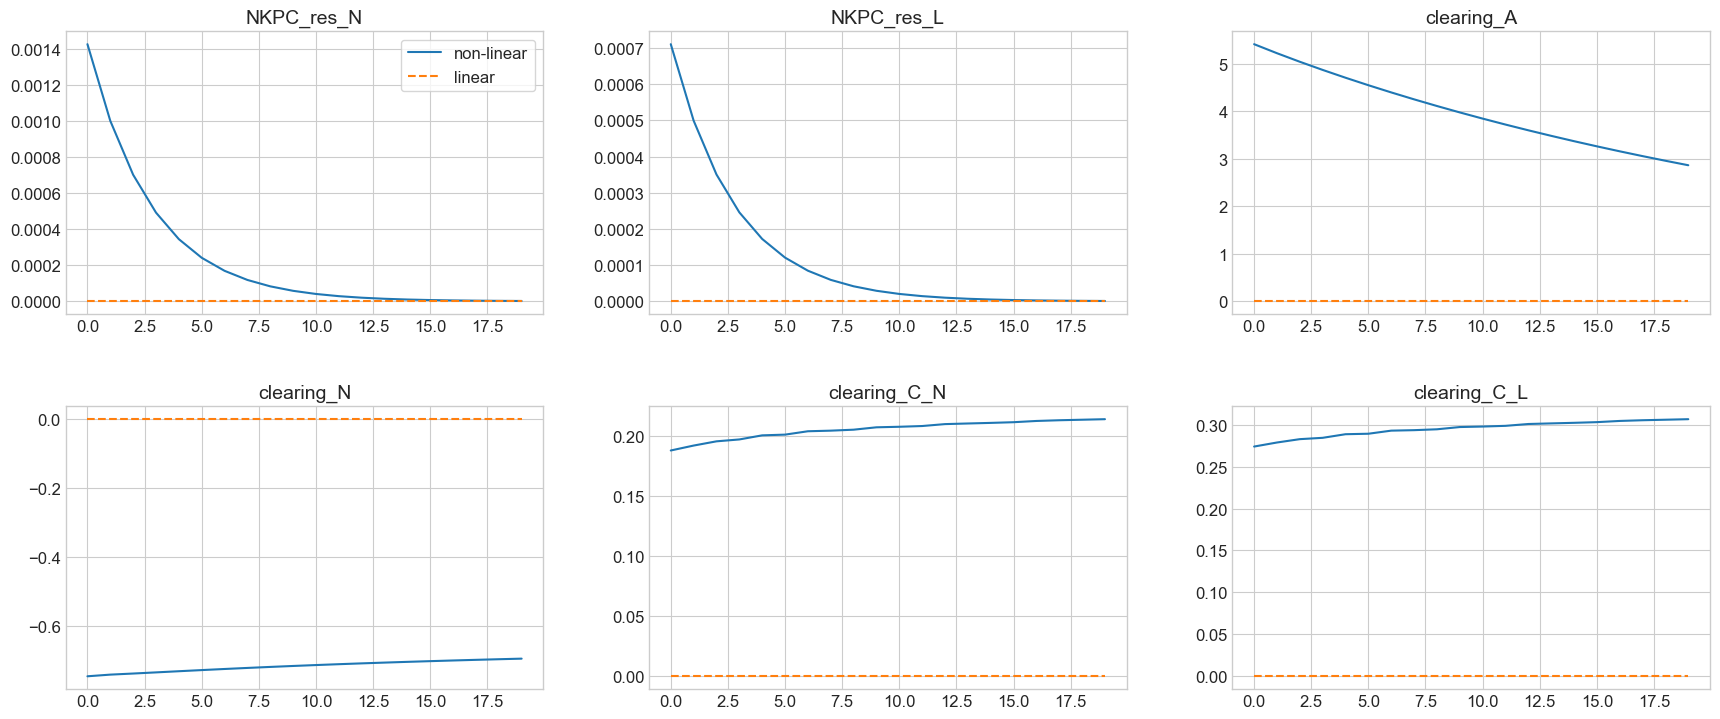

In [ ]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

KeyboardInterrupt: 

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()